In [1]:
import orbipy as op
import numpy as np
import pandas as pd

In [2]:
import pickle

In [3]:
import glob

In [4]:
from IPython.display import clear_output

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
model = op.crtbp3_model()
precise_model = op.crtbp3_model()
precise_model.integrator.set_params(max_step=np.pi/180)
stm_model = op.crtbp3_model(stm=True)

In [12]:
# Earth-L1 distance:
EL1_dist = (1.0-model.mu) - model.L1
EL1_dist

0.009968050664477479

In [13]:
# borders
left = op.eventX(model.L1-EL1_dist)
right = op.eventX(model.L1+EL1_dist-5000/model.R)

In [14]:
plotter = op.plotter.from_model(model, length_units='Mm', velocity_units='km/s')

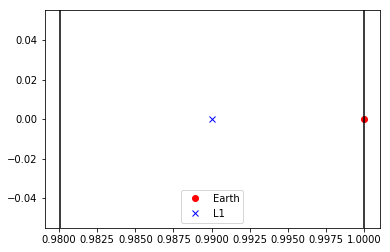

In [31]:
plt.plot(1.0-model.mu, 0.0, 'or', label='Earth')
plt.plot(model.L1, 0.0, 'xb', label='L1')
plt.axvline(model.L1-EL1_dist,c='k')
plt.axvline(model.L1+EL1_dist-5000/model.R,c='k')
plt.legend()

In [226]:
s0 = model.get_zero_state()
s0[0] = model.L1 - 40000/model.R
s0[2] = 700000/model.R

In [42]:
first_corr = op.border_correction(model, op.y_direction(), [left], [right])
corr = op.border_correction(model, op.unstable_direction(stm_model), [left], [right])

In [43]:
#events=[vx_stop, vy_stop, vz_stop]

In [44]:
sk = op.simple_station_keeping(precise_model, first_corr, corr, rev=np.pi/2)

In [231]:
df = sk.prop(0.0, s0, 50, ret_df=False)

Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 


In [232]:
df.shape

(4371, 7)

In [60]:
#sk.dvout[:,-3:]

In [61]:
#sk.evout

In [17]:
scaler = plotter.scaler

In [45]:
step = 10000/model.R
#zpoint = -step
zlv = 71
for i in range(35):
    zlv += 1
    zpoint = zlv*step
    xpoint = left.value
    z_row = []
    while xpoint < right.value:
        xpoint += step
        print('z level: {} km'.format(scaler(zpoint,'nd-km')))
        print('x level: {} km'.format(scaler(xpoint,'nd-km')))
        s0 = model.get_zero_state()
        s0[0] = xpoint
        s0[2] = zpoint
        try: 
            df = sk.prop(0.0, s0, N=50)
        except Exception as e:
            print('s0: ',s0)
            print(e)
        else:
            out = {}
            #out['conv'] = np.abs(np.amax(sk.dvout[:,-3:])) < 1e-4
            out['dv'] = sk.dvout[:,-3:]
            out['orbit'] = df
            z_row.append(out)
            clear_output()
    pickle.dump(z_row, open('Log/{}.bin'.format(zlv),'wb'))
print(zpoint)

z level: 170000.0 km
x level: 149597110.23947147 km
Simple station-keeping: 

c:\users\alexander\anaconda3\envs\orbits\lib\site-packages\scipy\integrate\_ode.py:1177: UserWarning: dop853: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))


s0:  [0.99998068 0.         0.00113636 0.         0.         0.        ]
Borders unreachable
0.0011363636363636363


In [254]:
int(10*step)

0

In [46]:
fnames = glob.glob('Log/*.bin')

In [47]:
valid_stp = []
for name in fnames:
    z_row = pickle.load(open(name, 'rb'))
    for elem in z_row:
        if np.abs(elem['dv'][1:]).max() < 1e-4:
            valid_stp.append(np.array(elem['orbit'].loc[0, ['x','z']]))

In [51]:
valid_stp = np.array(valid_stp)
valid_stp = scaler(valid_stp, 'nd-km')

In [55]:
valid_stp

array([[1.4756711e+08, 0.0000000e+00],
       [1.4757711e+08, 0.0000000e+00],
       [1.4758711e+08, 0.0000000e+00],
       ...,
       [1.4911711e+08, 9.0000000e+04],
       [1.4912711e+08, 9.0000000e+04],
       [1.4913711e+08, 9.0000000e+04]])

(146467988.20152864, 149748673.0362215, -34999.99999999997, 734999.9999999994)

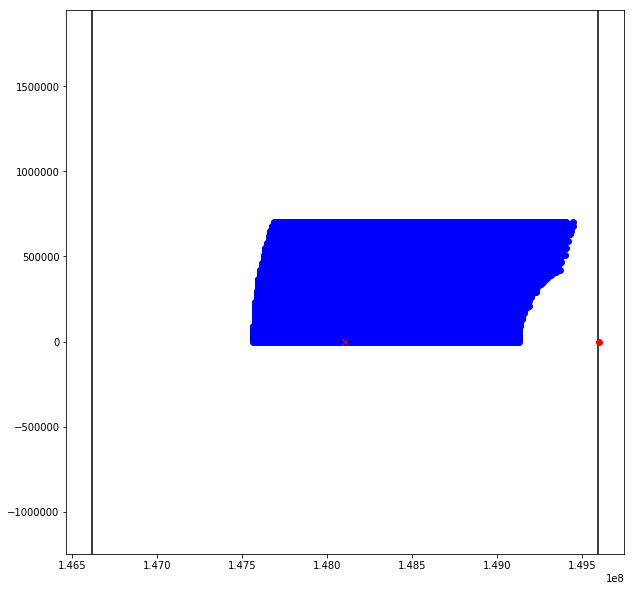

In [59]:
plt.figure(figsize=(10,10))
plt.plot(valid_stp[:,0], valid_stp[:,1], 'ob')
plt.axvline(scaler(left.value, 'nd-km'),c='k')
plt.axvline(scaler(right.value, 'nd-km'),c='k')
plt.plot(scaler(1.0-model.mu, 'nd-km'), 0.0, 'or', label='Earth')
plt.plot(scaler(model.L1, 'nd-km'), 0.0, 'xr', label='L1')
plt.ylim(-10, 15000000)
plt.axis('equal')
